# Conditional MNIST example

In the last notebook we looked at the creation of handwritten digits. However we could not control which numbers where generated because we had no idea how the GAN mapped the different digits from 0-9 in the latent space. In this tutorial where forcing the network to learn a specific distribution for every digit such that we have control over the output when generating new examples. Note that this comes at a cost: While so far all examples where performed in an unsupervised way (menaing you didn't use the labels of the data) this approach needs labeled data.

First import the usual libraries:

In [1]:
import os
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.preprocessing import OneHotEncoder

os.chdir("/home/thomas/Backup/Algorithmen/GAN-pytorch")
# vegans imports:

from vegans.GAN import ConditionalWassersteinGAN, ConditionalWassersteinGANGP
from vegans.utils.utils import plot_losses, plot_images, get_input_dim

ngpu = 0

Check if your machine has an available GPU for usage.

In [2]:
print('Cuda is available: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda is available: True


In [3]:
# This directory should contain "train_images.pickle and test_images.pickle"
datapath_train = "/home/thomas/Backup/Algorithmen/GAN-pytorch/data/mnist/train_images.pickle"
datapath_test = "/home/thomas/Backup/Algorithmen/GAN-pytorch/data/mnist/test_images.pickle"

# Hidden layer channels for generator / critic
ngf = 8
ncf = 4

# Padding for mnist images (28x28) -> (32x32)
pad = 2

Now load and preprocess the data:
- The images are saved in gray scale from 0-255, so we scale it to 0-1. Then we can use a Sigmoid as the last layer of the generator.
- The original image shape is (28, 28) but when working with convolutional layers it is often beneficial to have a power of two. Therefore we pad two empty rows and columns to every image.
- Finally we reshape the images because we need the images in the shape of (nr_channels, nr_heiht_pixels, nr_width_pixels). In out case this results in [1, 32, 32]

In [4]:
""" Create dataset
"""
with open(datapath_train, "rb") as f:
    X_train, y_train = pickle.load(f)

with open(datapath_test, "rb") as f:
    X_test, y_test = pickle.load(f)
    
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)
X_train = np.pad(X_train, [(0, 0), (pad, pad), (pad, pad)], mode='constant').reshape(-1, 1, 32, 32)
X_test = np.pad(X_test, [(0, 0), (pad, pad), (pad, pad)], mode='constant').reshape(-1, 1, 32, 32)
print(X_train.shape, X_test.shape)

(60000, 1, 32, 32) (10000, 1, 32, 32)


Now we plot the handwritten digits, this time using the labels because we anyway need them later for this supervised algortihm.

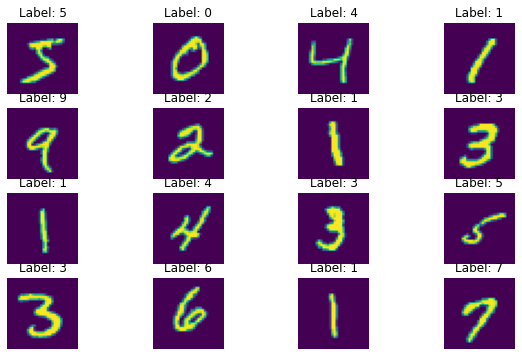

In [5]:
fig, axs = plot_images(images=X_train.reshape(-1, 32, 32), labels=y_train, n=16)

We need to pass the labels as one hot encoded vectors so we use the scikit-learn library to transform the data.

In [6]:
one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = one_hot_encoder.transform(y_test.reshape(-1, 1))
print(y_train.shape, y_test.shape)

(60000, 10) (10000, 10)


We now define all the different input sizes for the discriminator and generator. Note that internally the images X_train are concatenated with the labels before passing them to the discriminator / critic. The labels are also concatenated with the noise so that the generator as well as the adversariat can learn to differentiate between images of different digits. To calculate the number of input channels / features we can use a utility functiion called `get_input_dim(dim1, dim2)`.

In [7]:
x_dim = X_train.shape[1:]
y_dim = y_train.shape[1:]
z_dim = [1, 4, 4]

print("x_dim:", x_dim, "y_dim:", y_dim, "z_dim:", z_dim)
adv_in_dim = get_input_dim(dim1=x_dim, dim2=y_dim)
gen_in_dim = get_input_dim(dim1=z_dim, dim2=y_dim)
print("Adv_dim:", adv_in_dim, "Gen_dim:", gen_in_dim)

x_dim: (1, 32, 32) y_dim: (10,) z_dim: [1, 4, 4]
Adv_dim: [11, 32, 32] Gen_dim: [11, 4, 4]


Note that the labels get concatenated with the channel axis of both the `z_dim` and `x_dim`. You could choose for `z_dim` a single integer as well and it would return the correct amount of features.

### Definition of Generator and Discriminator / Critic
We'll specify the architecture of the generator and discriminator / critic networks. It's difficult to know which architectures to choose before training. Here we used a architecture which proved to work.

Since we want to train a Wasserstein GAN, the output of the critic should be a real number and not a probability. Therefore we drop the last sigmoid and use the identity function. If you want to switch to a architecture that uses a discriminator switch the `nn.Identity` with `nn.Sigmoid` for the adversariat.

In [10]:
""" Generator
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.hidden_part = nn.Sequential(
            nn.ConvTranspose2d(gen_in_dim[0], ngf * 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, 1, 5, 1, 2, bias=False),
        )
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
""" Discriminator
"""
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.hidden_part = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(adv_in_dim[0], ncf, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ncf, ncf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ncf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ncf * 2, ncf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ncf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ncf * 4, ncf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ncf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 2 x 2
            nn.Conv2d(ncf * 8, 1, 2, 1, 0, bias=False)
        )
        self.output = nn.Identity()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
generator = Generator()
critic = Critic()

### Train our GAN
Build a Wasserstein GAN trainer, using default optimizers (we can also specify our own). To use a different GAN algorithm, just use the corresponding class (e.g., `VanillaGAN` for original GAN).

Here you can specify some optional GAN parameters, such as the latent space dimension `z_dim`, the number of samples to save (`fixed_noise_size`) and the optimizer keyword arguments (`optim_kwargs`).  We also decrease the learning rate of the critic a little.

For this conditional algorithm we also need to pass in the dimension of the one hot encoded labels.

In [11]:
optim_kwargs = {"Generator": {"lr": 0.0005}, "Adversariat": {"lr": 0.0001}}
gan = ConditionalWassersteinGAN(
    generator, critic, z_dim=z_dim, x_dim=x_dim, y_dim=y_dim, ngpu=ngpu, 
    optim_kwargs=optim_kwargs, fixed_noise_size=20, folder=None
)

In [12]:
gan.summary()

Generator
Input shape:  (11, 4, 4)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 4, 4]           6,336
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
   ConvTranspose2d-4             [-1, 32, 8, 8]          32,768
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
   ConvTranspose2d-7           [-1, 16, 16, 16]           8,192
       BatchNorm2d-8           [-1, 16, 16, 16]              32
              ReLU-9           [-1, 16, 16, 16]               0
  ConvTranspose2d-10            [-1, 8, 32, 32]           2,048
      BatchNorm2d-11            [-1, 8, 32, 32]              16
             ReLU-12            [-1, 8, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 32, 32]             200
    

Train the networks by calling the `fit()` method. Here you can specify some parameters for training like `eochs`, `batch_size`, `save_model_every`, `save_images_every`, `print_every`, `enable_tensorboard` and others.

You can interrupt training at any time and still access train stats from within the `gan` object. You can resume training later. Note that we increase the number of steps the critic (adversariat) is trained, which is common for Wasserstein GANs but not VanillaGANs so take care when switching out algorithms.

In [14]:
steps = {"Adversariat": 5}
gan.fit(
    X_train, y_train, X_test, y_test, epochs=5, steps=steps,
    print_every="0.25e", save_losses_every=10, enable_tensorboard=False
)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------
Step: 468 / 9375 (Epoch: 1 / 5, Batch: 468 / 1875)
------------------------------------------------------------
Generator: -0.00018875951354857534
Adversariat: -0.00020376767497509718
Adversariat_fake: 0.0001887595426524058
Adversariat_real: -0.0005962948780506849
Loss/LossRatio: -3.1590185165405273


Time left: ~7.083 minutes (Batches remaining: 8907).


Step: 936 / 9375 (Epoch: 1 / 5, Batch: 936 / 1875)
------------------------------------------------------------
Generator: -0.0006851834477856755
Adversariat: -0.00028444110648706555
Adversariat_fake: 0.0006851833313703537
Adversariat_real: -0.0012540655443444848
Loss/LossRatio: -1.8302627801895142


Time left: ~6.652 minutes (Batches remaining: 8439).


Step: 1404 / 9375 (Epoch: 1 / 5, Batch: 1404 / 1875)
------------------------------------------------------------
Generator: -0.00011462988913990557
Adver

Investigate the results and loss curves.

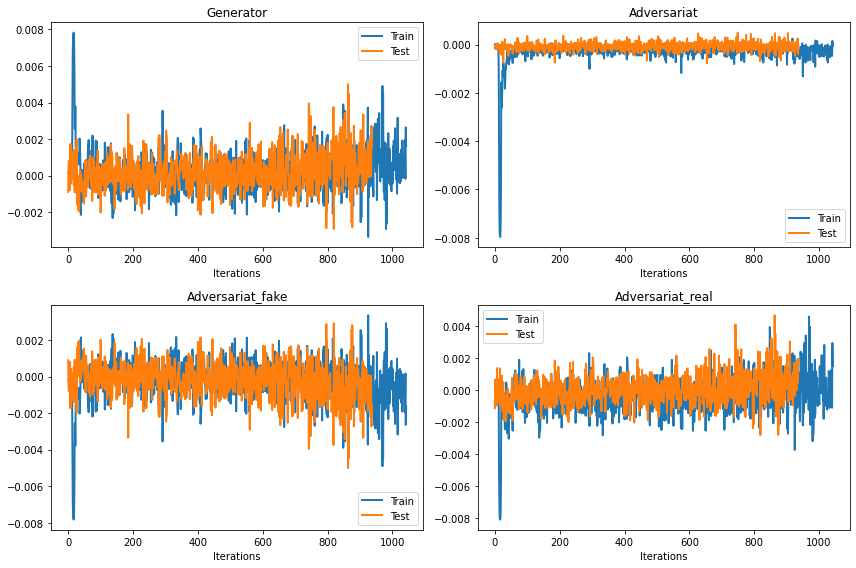

(20, 1, 32, 32)


In [15]:
samples, losses = gan.get_training_results()
fig, axs = plot_losses(losses)
print(samples.shape)

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


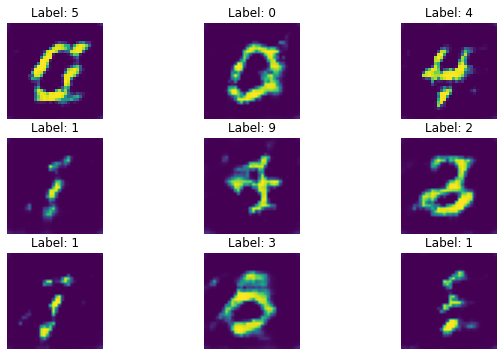

In [23]:
fixed_labels = np.argmax(gan.fixed_labels.cpu().detach().numpy(), axis=1)
fig, axs = plot_images(samples.reshape(-1, 32, 32), n=9, labels=fixed_labels)

Now we want to generate new images and have control over the number of generated images. Note that the `get_training_results` returns as many images as were specified with the `fixed_noise_size` argument in the constructor when creating the GAN.

In [25]:
my_labels = np.zeros(shape=(10, 10))
np.fill_diagonal(my_labels, 1)
new_samples = gan.generate(y=my_labels)
print(new_samples.shape)
fig, axs = plot_images(samples.reshape(-1, 32, 32), labels=list(range(10)))

AttributeError: 'numpy.ndarray' object has no attribute 'to'